In [1]:
!git clone https://github.com/aman190202/udemy-nerf.git

Cloning into 'udemy-nerf'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (281/281), done.
remote: Total 299 (delta 30), reused 278 (delta 12), pack-reused 0
Receiving objects: 100% (299/299), 13.77 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
%cd udemy-nerf/

/content/udemy-nerf


In [3]:
import torch
from torch import nn
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import get_rays
from model import Voxels
from rendering import rendering

In [4]:
datapath = 'fox'
batch_size = 1024

o, d, target_px_values = get_rays(datapath,'train')
test_o, test_d, test_target_px_values = get_rays(datapath,'test')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1,3),torch.from_numpy(d).reshape(-1,3),torch.from_numpy(target_px_values).reshape(-1,3)),dim=1),
                        batch_size=batch_size,shuffle=True)

(90, 400, 400, 4)
(10, 400, 400, 4)


In [5]:
from tqdm import tqdm
from rendering import rendering
import torch

def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='cpu'):

    training_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)

            target = batch[:, 6:].to(device)

            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)

            loss = ((prediction - target)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

        scheduler.step()

        torch.save(model.cpu(), 'model_nerf')
        model.to(device)

    return training_loss

In [6]:
device = 'cuda'
model = Voxels(scale=3,device = device)
nb_epochs = 15
nb_bins = 100
lr = 1e-3
gamma = 0.5
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma = gamma)
tn = 8
tf = 12
n_bins = 100

training = training (model,optimizer,scheduler,tn,tf,nb_bins,nb_epochs,dataloader,device=device)

100%|██████████| 14063/14063 [02:03<00:00, 113.45it/s]


In [8]:
img = rendering(model,torch.from_numpy(o[0]).to(device),torch.from_numpy(d[0]).to(device),tn,tf,nb_bins=100,device=device)

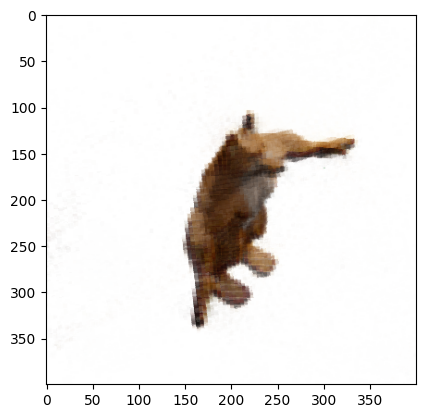

In [10]:
import matplotlib.pyplot as plt
plt.imshow(img.reshape(400,400,3).data.cpu().numpy())